# IMDB Binary Classifier 

This work is related to a data science take-home assignment that was tightly time boxed.

## Overview

The objective is to apply exploratory data analysis and machine learning techniques to the provided imdb dataset so that key features related to producing a successful film may be identified.

We'll explore the associations between the following features:

1. Top 10 movie titles by **movie_score**, **return_on_investment**, & **profit**
2. Top 10 directors by **profit** & average **movie_score** 
3. Top 10 leading actors by **profit** & average **movie_score** 
4. **movie_score** by **duration** & **genre**

We'll also create a simple binary classification model that predicts whether a given film will have a **movie_score** that is above the median.

# Data Profiling
## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.gofplots import qqplot
import scipy
import seaborn as sns
import statsmodels
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, accuracy_score, precision_score, \
recall_score, classification_report, confusion_matrix
import warnings
import os
from sklearn import metrics
from utils import is_good_movie, compute_missing_data, millions, imputate, create_categories, encode_and_strip_whitespace,\
drop_rare_val_cols, label_encoder
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Create a dataframe from the CSV

In [2]:
df = pd.read_csv("imdb_5000.csv")
df.head()

,color,director_name,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.00,178.00,0.00,855.00,Joel David Moore,1000.00,760505847.00,Action|Adventure|Fantasy|Sci-Fi,...,3054.00,English,USA,PG-13,237000000.00,2009.00,936.00,7.90,1.78,33000
1,Color,Gore Verbinski,302.00,169.00,563.00,1000.00,Orlando Bloom,40000.00,309404152.00,Action|Adventure|Fantasy,...,1238.00,English,USA,PG-13,300000000.00,2007.00,5000.00,7.10,2.35,0
2,Color,Sam Mendes,602.00,148.00,0.00,161.00,Rory Kinnear,11000.00,200074175.00,Action|Adventure|Thriller,...,994.00,English,UK,PG-13,245000000.00,2015.00,393.00,6.80,2.35,85000
3,Color,Christopher Nolan,813.00,164.00,22000.00,23000.00,Christian Bale,27000.00,448130642.00,Action|Thriller,...,2701.00,English,USA,PG-13,250000000.00,2012.00,23000.00,8.50,2.35,164000
4,NaN,Doug Walker,nan,nan,131.00,nan,Rob Walker,131.00,nan,Documentary,...,nan,NaN,NaN,NaN,nan,nan,12.00,7.10,nan,0


## Shape

In [3]:
rows, cols = df.shape
print("There are {} rows and {} columns.".format(rows, cols))

There are 5043 rows and 26 columns.


## Dataset Info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_reviews         4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_users_voted            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

There are missing values that should be investigated.

# Data Quality and Cleansing
## Dropping duplicate rows

In [5]:
df = df.drop_duplicates(['movie_title'],keep= 'last')
print("There are {} rows remaining.".format(df.shape[0]))

There are 4916 rows remaining.


## Missing value ratios

In [6]:
missing_data = compute_missing_data(df)
missing_data

,Missing Ratio
gross,17.51
budget,9.83
aspect_ratio,6.61
content_rating,6.12
plot_keywords,3.07
title_year,2.14
director_name,2.05
director_facebook_likes,2.05
num_critic_reviews,1.00
actor_3_facebook_likes,0.47


We have relatively high missing ratios for **gross** and **budget**. We'll drop any rows with missing **gross** or **budget** values since imputation on those columns could be problematic. 

In [7]:
df = df.dropna(subset=["gross", "budget"])
print("There are {} rows remaining.".format(df.shape[0]))

There are 3789 rows remaining.


We'll perform imputation on the remaining columns in the feature engineering step.

## Cleaning up **movie_title** 

* We'll strip whitespaces and remove the strange characters

In [8]:
df['movie_title'] = df['movie_title'].apply(lambda x:encode_and_strip_whitespace(x))

#  Feature Engineering

## Imputation

* For any numeric columns, we'll fill in missing values with the mean.
* For any non-numeric columns, we'll fill in missing values with the string **unknown**.

In [9]:
na_columns = list(missing_data.index)
na_columns_numeric = [col for col in na_columns if df[col].dtype in ["float64", "int64"]]
na_columns_categorical = [col for col in na_columns if col not in na_columns_numeric]
df = imputate(df=df, cols=na_columns_numeric, data_type="numeric")
df = imputate(df=df, cols=na_columns_categorical, data_type="object")

### Verifying that there are no nulls remaining in the data set.

In [10]:
missing_data = compute_missing_data(df)
assert missing_data.shape[0] == 0, "There are nulls remaining in the dataset."

## Create target variable

We're developing a binary classifier but lack a column containing true and false values. We'll add a column called **is_good_movie** with the following rules:

* If a **movie_score** is above the median, a 1 is assigned
* Else, a 0 is assigned

In [11]:
df['is_good_movie'] = df["movie_score"].apply(lambda x: is_good_movie(df=df, x=x))

## Creating primary_genre from genres
* Because a given film may fall into one or more genres, we'll create a new feature called primary_genre.

In [12]:
df['genres'] = df['genres'].str.split('|')
df['primary_genre'] = df['genres'].apply(lambda x:x[0])
df = df.drop(['genres'], axis=1)

## Adding **profit** and **return_on_investment** columns

### **profit** is the difference between **gross** and **budget**

In [13]:
df["profit"] = df["gross"] - df["budget"]

### **return_on_investment** is the ratio of **gross** and **budget**

In [14]:
df["return_on_investment"] = (df["profit"]/df["budget"])*100

## Quantile binning on budget

According to the [Google's ML Crash Course](https://developers.google.com/machine-learning/crash-course/representation/qualities-of-good-features#avoid-rarely-used-discrete-feature-values): 

    "Good feature values should appear more than 5 or so times in a data set. Doing so enables a model to learn how this feature value relates to the label. That is, having many examples with the same discrete value gives the model a chance to see the feature in different settings, and in turn, determine when it's a good predictor for the label. If a feature's value appears only once or very rarely, the model can't make predictions based on that feature."

### Let's use quantiles to bin the values into **very_low**, **low**, **high**, **very_high** categories.

In [15]:
df['budget_categories'] = df['budget'].apply(lambda x:create_categories(df=df, x=x, col="budget"))
df = df.drop(["budget"], axis=1)

## Quantile binning on facebook related features

### Similar to 5.4, we'll use quantile binning to eliminate uniqueness.

In [16]:
fb_cols = [col for col in df.columns if "facebook" in col]
for col in fb_cols:
    df['{}_category'.format(col)] =  df[col].apply(lambda x:create_categories(df=df, x=x, col=col))
    df = df.drop([col], axis=1)

# Exploratory Analysis

## Distribution of **movie_score**

* Let's generate histogram and quantile plots to identify any potential skewness.

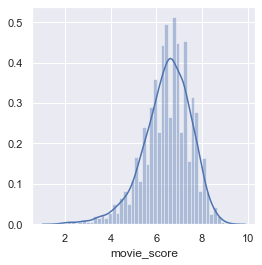

In [17]:
sns.set(rc={'figure.figsize':(4,4)})
sns.distplot(df["movie_score"], color="b")

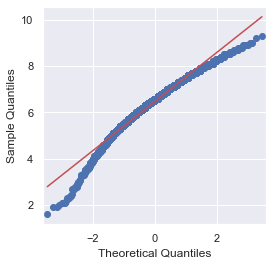

In [18]:
qqplot(df["movie_score"], line='s')
plt.show()

It seems that our distribution is left-skewed. We'll refer to median as the average.

In [19]:
print("The median movie_score is {}".format(df["movie_score"].median()))

The median movie_score is 6.6


### Distribution of target variable

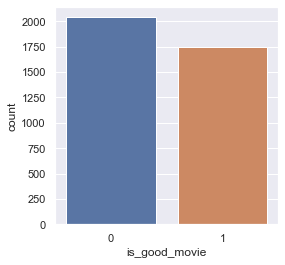

In [20]:
sns.countplot(df['is_good_movie'])

Our classes are imbalanced. 

## Top 10 movies ranked by **movie_score**

In [21]:
df_title_score = df[["movie_title", "title_year", "movie_score"]
                 ].sort_values(["movie_score"], ascending=False).head(10).reset_index(drop=True)
df_title_score

,movie_title,title_year,movie_score
0,The Shawshank Redemption,1994.00,9.30
1,The Godfather,1972.00,9.20
2,The Godfather: Part II,1974.00,9.00
3,The Dark Knight,2008.00,9.00
4,"The Good, the Bad and the Ugly",1966.00,8.90
5,Schindler's List,1993.00,8.90
6,Pulp Fiction,1994.00,8.90
7,The Lord of the Rings: The Return of the King,2003.00,8.90
8,The Lord of the Rings: The Fellowship of the Ring,2001.00,8.80
9,Forrest Gump,1994.00,8.80


In [22]:
df_title_score.describe()

,title_year,movie_score
count,10.00,10.00
mean,1989.90,8.97
std,14.25,0.16
min,1966.00,8.80
25%,1978.75,8.90
50%,1994.00,8.90
75%,1999.25,9.00
max,2008.00,9.30


* The average **title_year** of this subset is 1990.

## Top 10 movies ranked by **return_on_investment**

In [23]:
df_title_roi = df[["movie_title", "return_on_investment", "movie_score"]
                 ].sort_values(["return_on_investment"], ascending=False).head(10).reset_index(drop=True)
df_title_roi

,movie_title,return_on_investment,movie_score
0,Paranormal Activity,719348.55,6.30
1,Tarnation,271466.06,7.20
2,The Blair Witch Project,234116.86,6.40
3,The Brothers McMullen,40886.40,6.60
4,The Texas Chain Saw Massacre,36842.73,7.50
5,El Mariachi,29056.00,6.90
6,The Gallows,22657.82,4.20
7,Super Size Me,17637.49,7.30
8,Halloween,15566.67,7.90
9,American Graffiti,14700.51,7.50


### Top movies by ROI & & below average **movie_score**

In [24]:
df_title_roi[df_title_roi["movie_score"] < df["movie_score"].median()]

,movie_title,return_on_investment,movie_score
0,Paranormal Activity,719348.55,6.30
2,The Blair Witch Project,234116.86,6.40
6,The Gallows,22657.82,4.20


* Paranormal Activity has an ROI of over 700000%.
* 3 of the films in this subset have below average movie scores.

Caveat: 
* ROI alone is not sufficient metric in identifying successful movie productions. Instead, we should rank the top 20 movie titles by gross profit and then sort those titles by ROI.

## Top 10 Movies by **profit** & **return_on_investment**
### Top 10 movie titles by profit

In [25]:
df_title_profit = df[["movie_title", "director_name","title_year","profit", "return_on_investment","movie_score"]
                 ].sort_values(["profit"], ascending=False).head(10).reset_index(drop=True)

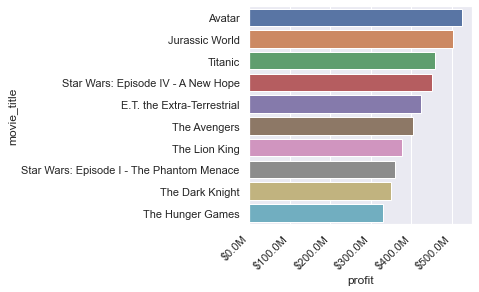

In [26]:
formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
ax.xaxis.set_major_formatter(formatter)
sns.barplot(x="profit", y="movie_title", data=df_title_profit)

### Movies with below average **movie_score**

In [27]:
list(df_title_profit[df_title_profit["movie_score"] < df["movie_score"].median()].movie_title)

['Star Wars: Episode I - The Phantom Menace']

### Which film has the highest ROI?

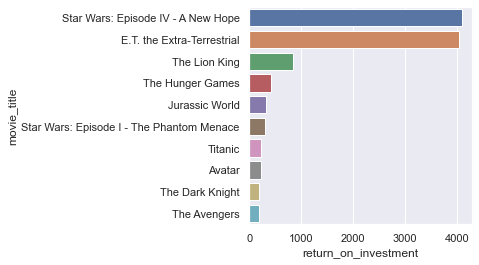

In [28]:
df_title_profit_roi = df_title_profit.sort_values(["return_on_investment"], ascending=False).reset_index(drop=True)
sns.barplot(x="return_on_investment", y="movie_title", data=df_title_profit_roi)

* Avatar is the top movie by profit.
* Star Wars: Episode IV - A New Hope has the highest ROI of over 4000%.
* Star Wars: Episode I - The Phantom Menace has a movie_score that is marginally below the median. 

## Top 10 directors ranked by **profit**

In [29]:
df_top_directors_profit = df[["director_name","profit"]].groupby(["director_name"]).sum()
df_top_directors_profit = df_top_directors_profit.sort_values(["profit"], ascending=False)
df_top_directors_profit["director_name"] = df_top_directors_profit.index
df_top_directors_profit = df_top_directors_profit.reset_index(drop=True)
df_top_directors_profit = df_top_directors_profit[["director_name", "profit"]]
df_top_directors_profit = df_top_directors_profit.head(10)

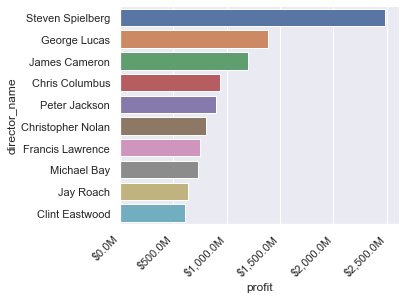

In [30]:
sns.set(rc={'figure.figsize':(5,4)})
fig, ax = plt.subplots()
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
ax.xaxis.set_major_formatter(formatter)
sns.barplot(x="profit", y="director_name", data=df_top_directors_profit)

### What is the distribution of movie scores for these directors?

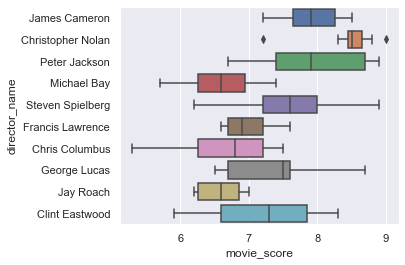

In [31]:
top_director_names_list = df_top_directors_profit["director_name"].tolist()
df_top_director_movie_scores = df[df["director_name"].isin(top_director_names_list)]
ax = sns.boxplot(x="movie_score", y="director_name", data=df_top_director_movie_scores)

### Directors with below average movie score

In [32]:
df_top_director_movie_scores_avg = df_top_director_movie_scores.groupby(["director_name"]).median()
list(df_top_director_movie_scores_avg[df_top_director_movie_scores_avg["movie_score"] < df["movie_score"].median()].index)

[]

* Steven Spielberg and his successful franchises have generated an overall profit of $2.5 billion.
* All of the top 10 directors have an above average **movie_score**.
* Christopher Nolan has the highest average movie score of ~8.5.

## Top 10 lead actors
### Ranked by **profit**

In [33]:
df_top_actors_profit = df[["actor_1_name","profit"]].groupby(["actor_1_name"]).sum()
df_top_actors_profit = df_top_actors_profit.sort_values(["profit"], ascending=False)
df_top_actors_profit["actor_1_name"] = df_top_actors_profit.index
df_top_actors_profit = df_top_actors_profit.reset_index(drop=True)
df_top_actors_profit = df_top_actors_profit[["actor_1_name", "profit"]]
df_top_actors_profit = df_top_actors_profit.head(10)

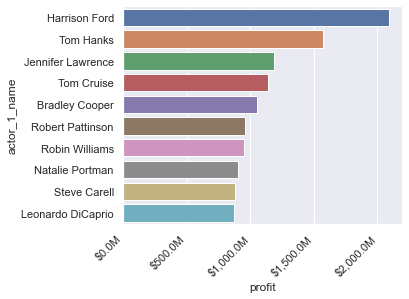

In [34]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)
g = sns.barplot(x="profit", y="actor_1_name", data=df_top_actors_profit)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.show()

###  Top lead actors & average movie scores

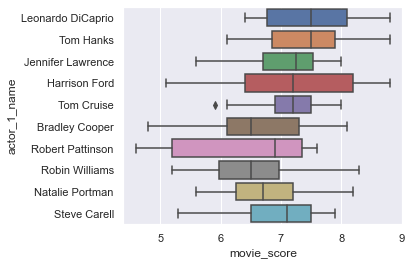

In [35]:
top_actor_names_list = df_top_actors_profit["actor_1_name"].tolist()
df_top_actor_movie_scores = df[df["actor_1_name"].isin(top_actor_names_list)]
ax = sns.boxplot(x="movie_score", y="actor_1_name", data=df_top_actor_movie_scores)

###  Top lead actors with below average **movie_score**

In [36]:
df_top_actor_movie_scores_avg = df_top_actor_movie_scores.groupby(["actor_1_name"]).median()
df_top_actor_movie_scores_avg['movie_score'][df_top_actor_movie_scores_avg["movie_score"] < df["movie_score"].median()]

actor_1_name
Bradley Cooper   6.50
Robin Williams   6.50
Name: movie_score, dtype: float64

* Harrison Ford is the top profit generating actor in the data set; perhaps his success is related to his work with Steven Speilberg.
* Bradley Cooper and Robin Williams have average movie scores that are marginally below average.

## **movie_score** and **duration**

### Scatterplot

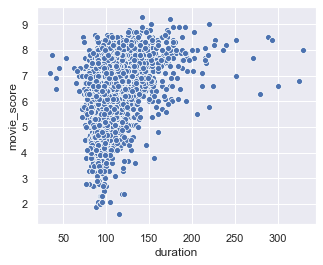

In [37]:
sns.scatterplot(x="duration", y="movie_score", data=df)

### Average duration for above average films

In [38]:
df_above_avg = df[df.movie_score > df.movie_score.median()]
print("The average duration for films with above average movie scores is {} minutes".format(df_above_avg.duration.median()))

The average duration for films with above average movie scores is 113.0 minutes


Below average **movie_score** data points become more sparse as the film **duration** increase i.e., there is a positive association between **movie_score** and **duration**.

### **primary_genre**  & average **movie_score** 

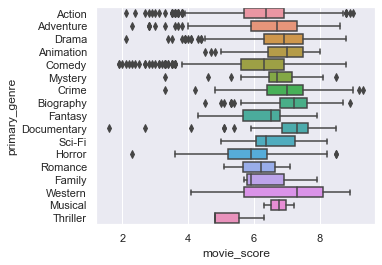

In [39]:
sns.boxplot(x="movie_score", y="primary_genre", data=df)

### **primary_genre** and **profit**

In [40]:
df_primary_genre_movie_score = df[['primary_genre', "profit", "movie_score"]].groupby(["primary_genre"]).median()
df_primary_genre_movie_score

,profit,movie_score
primary_genre,,
Action,-1554091.50,6.35
Adventure,3600000.00,6.70
Animation,14059016.00,7.00
Biography,-805934.00,7.20
Comedy,1873067.00,6.30
Crime,-61430.00,7.00
Documentary,-113700.00,7.30
Drama,-346236.50,6.90
Family,-4588020.00,5.90


### Identifying top genres with the following criteria:
* Average profit for the genre is above the median profit
* Average movie_score for the genre is above the median movie_score

In [41]:
df_top_genres_by_profit_score = df_primary_genre_movie_score[(df_primary_genre_movie_score.profit > df.profit.median()) & (df_primary_genre_movie_score.movie_score > 
                                                                                           df.movie_score.median())]
recommended_genres = list(df_top_genres_by_profit_score.index)
print("The recommended genres are: {}".format(", ".join(recommended_genres)))

The recommended genres are: Adventure, Animation, Musical, Mystery, Western


# Data preprocessing
##  Encode categorical features

* We'll use scikit-learn's LabelEncoder to encode the categorical features.

In [42]:
df = label_encoder(df)
print('Shape all_data: {}'.format(df.shape))

Shape all_data: (3789, 29)


Verifying that all columns have a numeric data type.

In [43]:
assert len([col for col in df.columns if df[col].dtype=="object"]) == 0

# Feature Selection 

## Drop features that are unknown at the time of prediction. 
* Since we want to build a model that predicts if a movie will be good or bad before it's released, we'll drop the following features:

    1. num_critic_reviews
    2. gross (revenue)
    3. num_users_voted
    4. num_user_reviews
    5. movie_facebook_likes
    6. profit
    7. return_on_investment

In [44]:
df = df.drop(["num_critic_reviews", "num_users_voted", "num_user_reviews", "profit", 
              "return_on_investment", "gross"], axis=1)

## Drop features with rarely used values
    
Let's drop any columns that have a unique value count > number of rows divide by 5. We'll do this programmatically.

In [45]:
df, dropped = drop_rare_val_cols(df)
print("The following columns were dropped: {}".format(dropped))

The following columns were dropped: ['director_name', 'actor_2_name', 'actor_1_name', 'movie_title', 'actor_3_name', 'plot_keywords']


## Identifying multicolinearity 

* We'll create a heatmap that represents the Pearson's correlation matrix to identify features that are strongly correlated.

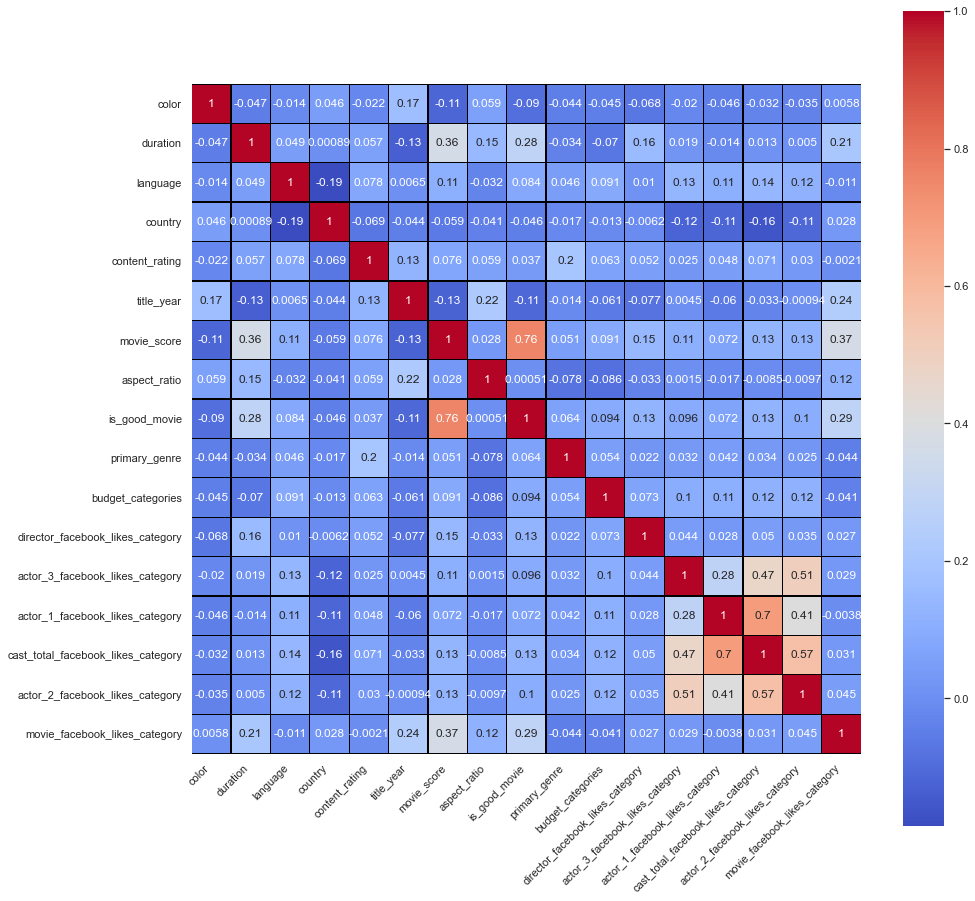

In [46]:
df_num = df.select_dtypes(include=["float64", "int64"])
f, ax = plt.subplots(figsize=(15, 15))
df_corr = df_num.astype(float).corr()
sns.heatmap(df_corr,linewidths=0.25,vmax=1.0,cmap = "coolwarm", square=True, linecolor='black', annot=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### The following features are strongly correlated with an R value >= 0.7:

1. **actor_1_facebook_likes_category** and **cast_total_facebook_likes_category** 
2. **movie_score** and **good_movie**

Dropping **cast_total_facebook_likes_category** and **movie_score**.

In [47]:
df = df.drop(["cast_total_facebook_likes_category","movie_score"], axis=1)

# Baseline Model

## Train-Test Split

In [48]:
y = df.is_good_movie
X = df.drop(['is_good_movie'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

## Create Model and Predictions

In [49]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
preds = gb.predict(X_test)[:]

## Evaluate Model
### Error metrics

In [50]:
print("Accuracy:",metrics.accuracy_score(y_test, preds))
print("Precision:",metrics.precision_score(y_test, preds))
print("Recall:",metrics.recall_score(y_test, preds))

Accuracy: 0.7651715039577837
Precision: 0.7341269841269841
Recall: 0.73558648111332


### ROC Curve

ROC is a plot of signal (True Positive Rate) against noise (False Positive Rate). The model performance is determined by looking at the area under the ROC curve (or AUC). The best possible AUC is 1 while the worst is 0.5 (the 45 degrees random line). (https://www.kdnuggets.com/2018/07/receiver-operating-characteristic-curves-demystified-python.html).

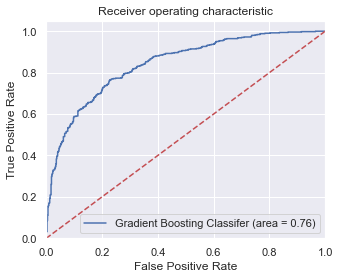

In [51]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, preds)
fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting Classifer (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GB_ROC')
plt.show()

### Confusion Matrix

Text(0.5, 12.5, 'Predicted label')

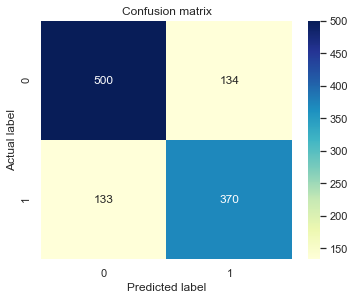

In [52]:
sns.set(rc={'figure.figsize':(5,4)})
cnf_matrix = metrics.confusion_matrix(y_test, preds)
class_names=[0,1] 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Feature Importances

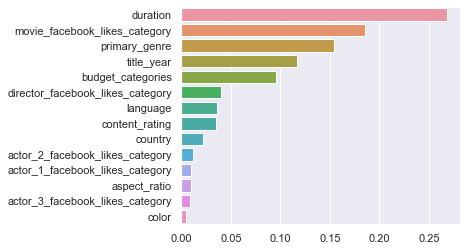

In [53]:
feat_importances = pd.Series(gb.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances.plot(kind='barh')
sns.barplot(x=feat_importances, y=feat_importances.index)

# Recommendations & Ideas
## Recommendations 
1. Hire one of the top 10 directors 
2. Films should have a duration of at least 113 minutes
3. Hire one or more of the top 10 lead actors with the exception of Bradley Cooper; RIP Robin Williams 
4. Focus on producing films that fall into one or more of the following genres:
    * Adventure
    * Animation
    * Musical
    * Mystery
    * Western
    
## Ideas to explore in the future
1. Explore the **content_rating** and **aspect_ratio** features
2. Identify and incorporate additional, 3rd party data sources (e.g., studio metadata, voter metadata)
3. Develop a recommender system using collaborative or content-based filtering
4. Apply text processing to the **plot_keywords** feature
5. Apply one-hot encoding to **genres** so that all subgenres are used as features

If there are any questions, please reach out to me via email at janelchumley@gmail.com 